## Skoltech
## Intro to data science, fall 2020
## Assigment 2

### Goals
- Make exploratory data analysis
- Apply feature engineering and feature selection
- Try to solve classification task and use classification performance metrics
- Get the taste of gradient boosting approach


# Submiting the answers

Google form to submit your answers: https://docs.google.com/forms/d/1zwUO1KZNDTZYuD12dyMO3CaErGHnZuHx1Mdbo-c11ME/

Use your **skoltech email**. For Name, Surname use **exactly the same spelling** as in canvas system.

---

If your answer is a ``float number``, then it must be provided with **3 decimals after the floating point**, e.g. 1.234

---

If your answer is a ``list of float or integer numbers or str``, then they should be reported in descending (alphabetical) order,  divided by a comma, e.g.:

10.453,9.112,5.001,5.000

---

The last part (Q5) do not have corresponding fields in the google form. It is **not optional** and it will be graded manually from your .ipynb file.

---

If you have any questions regarding this Home Assignment, ask them piazza topic: https://piazza.com/class/kespugtqfrn12g?cid=29

#### Import basic libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score
sns.set()


from sklearn.metrics import accuracy_score
from scipy.stats import iqr
sns.set()

import warnings
warnings.filterwarnings('ignore')

### Dataset
For the task we'll use kickstarter dataset. Kickstarter is the crowdfounding platform, where people can announce their project with financial goals and other can support the projects by paying the money ("pledging"). The goal will be to predict if the project will be successfull, i.e. would it achieve the funding goal. Let's take a brief look to the dataset.

In [2]:
df = pd.read_csv('ks-projects-201801.csv')
df.set_index("ID", inplace=True)

In [3]:
df.sample(5)

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
572561928,FRACTURE,Photography,Photography,USD,2012-09-22,46000.0,2012-08-23 21:18:47,15635.75,failed,76,US,15635.75,15635.75,46000.0
298022574,Eon Break,Video Games,Games,USD,2017-07-13,50000.0,2017-06-08 17:55:39,20268.00,failed,406,US,2156.00,20268.00,50000.0
995090055,Leather wallet/attaches to your phone/can beco...,Design,Design,USD,2016-07-19,8000.0,2016-06-04 20:46:11,5281.00,failed,33,US,3609.00,5281.00,8000.0
553185447,Pixel 2.0 - The Arduino compatible smart display!,DIY Electronics,Technology,USD,2017-03-15,5000.0,2017-02-22 15:00:10,10189.00,successful,101,US,2381.00,10189.00,5000.0
1572474304,FIRE EXPLORER,Young Adult,Publishing,USD,2015-06-13,50000.0,2015-04-14 06:12:47,0.00,failed,0,US,0.00,0.00,50000.0


In [4]:
df.shape

(378661, 14)

In [5]:
df.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

# Section 1. Dataset acquaintance

-----

### Q1.1

#### How many NaN values are there in the dataset?

In [6]:
df.isna().sum().sum()

3801

In [7]:
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

----

Let us simplify the task a little bit: we are aiming to predict either project fails or not.
Thus 'success' projects will be encoded as 1, with state ['failed', 'canceled'] as 0 and we remove the rows with any other state.

### Q1.2 
#### How many '1' values are in resulting dataset (in state column)?

-----

In [8]:
df = df.drop(df[(df["state"] == 'undefined')].index)
df = df.drop(df[df["state"] == 'live'].index)
df = df.drop(df[df["state"] == 'suspended'].index)


df['state'].loc[(df['state']=='failed')|(df['state']=='canceled')] = 0
df['state'].loc[(df['state']=='successful')] = 1
df.state = df.state.astype(int)

In [9]:
df['state'].value_counts()

0    236368
1    133851
Name: state, dtype: int64

In [10]:
df[df['state'] == 1].state.sum()

133851

------

### Q1.3
#### Whats is a name of a project attracted the biggest pay check? (on average). Use column usd_pledged_real to judge. If there are multiple projects, choose any single one.

In [11]:
df_temp = df[df['backers']!=0].copy()

df_temp['temp'] = df_temp['usd_pledged_real']/df_temp['backers']


In [12]:
df_temp[df_temp['temp']==df_temp['temp'].max()].name

ID
1459482568                   Patented (9 seasons) food enhancer
1767293256                                  KIRISUTOS PACHYDERM
1974395971    21st CENTURY MEDICAL PRACTICE SYSTEM THAT CHAN...
2024799289                                The Commoner Princess
281085395     "SUNBURN" - starring Michael Madsen, indie act...
472233286     Hollow Earth Project, Journey to the center of...
642968820                          Nobody: The Movie (Canceled)
889803741           Post Traumatic Stress (PTSD) Affects Us All
912587650              The Hare On The Chair - An Easter Legend
Name: name, dtype: object

-----

### Q1.4
#### What is the most successful main category (in terms of success percentage)?

-----

In [13]:
(df.groupby('main_category')['state'].sum()/df.groupby('main_category')['state'].count()).idxmax()

'Dance'

-----

### Q1.5
#### Define the category with highest goal per project. How many projects belong to it?  (note: we use category here, not main_category)

-----

In [14]:
c = df.groupby('category').goal.sum()/df.groupby('category').goal.count()
c.idxmax()

'Movie Theaters'

In [15]:
df[df['category'] == 'Movie Theaters'].shape[0]

227

-----

### Q1.6
#### What is the category with biggest total pledge? Use 'usd_pledged_real' to judge.

------

In [16]:
df.groupby('category')['usd_pledged_real'].sum().idxmax()

'Product Design'

------

As one can notice, there are both numerical and object-type data in our dataframe. 

We suggest you to split them to perform EDA separately. 

### Q1.7
#### Split columns to 'numeric' (by data type) and object-type. How many 'object-type' features are there?

In [17]:
(df.dtypes=='object').sum()

7

In [18]:
df.dtypes

name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                 int64
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

In [19]:
df_obj = df.select_dtypes(include='object')
df_num = df.select_dtypes(exclude='object')

### Q1.8
#### Let's do a bit of feature engineering. Let's create column 'pledge2goal' which define as ratio of usd_pledged_real to goal. How many outliers are there?
#### (We use a simple rule: an object is an outlier if it does not belong to [q25 - 1.5iqr, q75 + 1.5 iqr] interval, where qxx -- xx quantile, and iqr is inter-quantile range.)

In [20]:
df_num['pledged2goal'] = df_num['usd_pledged_real']/df_num['goal']
q_25, q_75 = df_num.pledged2goal.quantile([0.25, 0.75]).values

In [21]:
from scipy.stats import iqr
iqr = 1.5*iqr(df_num.pledged2goal.values)

In [22]:
interval = [q_25 - iqr, q_75 + iqr]

In [23]:
df_num[(df_num.pledged2goal > interval[1])|(df_num.pledged2goal < interval[0])].pledged2goal.shape[0]

18415

In [24]:
df_num = df_num.drop(df_num[(df_num.pledged2goal > interval[1])].index)
df_num = df_num.drop(df_num[(df_num.pledged2goal < interval[0])].index)

### Q1.9
#### Visualize the feature for success and fail cases. What can you say about received distributions? (use bins=10 or 20). Type letter as your answer
- A. Distributions intersect significantly, hard to say for sure that the ratio matters.
- B. Distributions have almost no intersection, the bigger ratio, the bigger success.
- C. Distributions have almost no intersection, the less ratio, the less success.
- D. Distributions have almost no intersection, the less ratio, the bigger success.

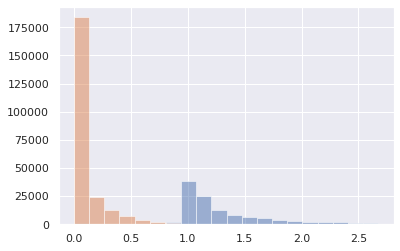

In [25]:
x_success = df_num[df_num['state']==1]['pledged2goal']
x_fail = df_num[df_num['state']==0]['pledged2goal']

num_bins = 20
hist1 = plt.hist(x_success, num_bins, (x_success.min(), x_success.max()), alpha = 0.5, label = 'success')
hist2 = plt.hist(x_fail, num_bins, (x_fail.min(), x_fail.max()), alpha = 0.5, label = 'fail')
plt.show()

#ans B

-----

### Q1.10
#### Continue with plot from Q1.9. Where are the peaks located? We expect two numbers here as the answer

-----

In [26]:
x1, x2 = np.argmax(hist1[0]), np.argmax(hist2[0])

In [27]:
round(hist1[1][x1],3), hist2[1][x2]

(0.942, 0.0)

In [28]:
# According to the hist the peaks are located near 0 and 0,942. 

-----

### Q1.11
#### Compute Pearson correlation coefficiton between the ratio and target variable. (Round up to second digit after point)

----

In [29]:
round(np.corrcoef(df_num['pledged2goal'], df_num['state'])[0][1],3)

0.902

-----

### Q1.12
#### Visualize dependancy of numerical data with success. What do you think of it?

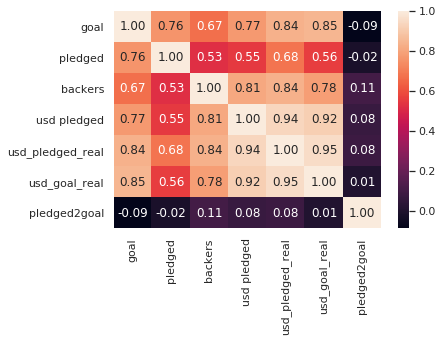

In [31]:
sns.heatmap(df_num[df.state == 1].drop(columns = ['state'], axis = 1).corr(), annot = True, fmt = '.2f')

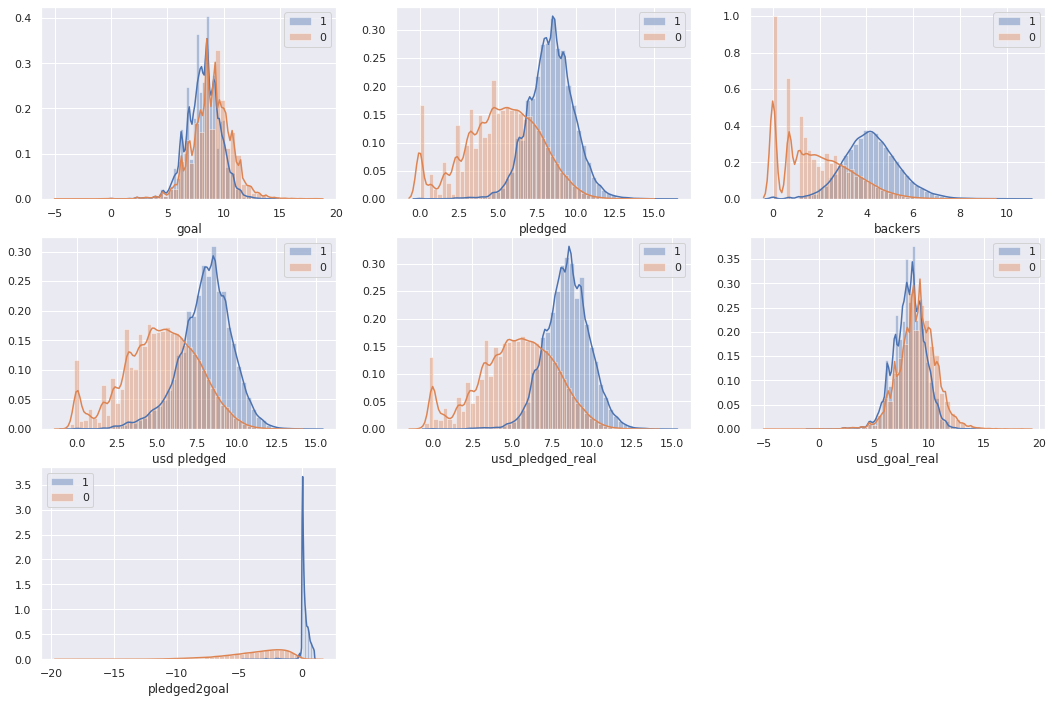

In [78]:
num_col = ['goal', 'pledged', 'backers', 'usd pledged','usd_pledged_real', 'usd_goal_real', 'pledged2goal']
plt.figure(figsize = (18, 12))
for num_col,col in enumerate(num_col):
    plt.subplot(3, 3, num_col+1)
    sns.distplot(np.log(df_num[df_num['state']==1][col]).replace([np.inf, -np.inf], np.nan).dropna(),label='1')
    sns.distplot(np.log(df_num[df_num['state']==0][col]).replace([np.inf, -np.inf], np.nan).dropna(),label='0')
    plt.legend()
    

It can be seen that all numerical features exept goal and usd_goal_real are leaked as there value affects an answer (the less the value the more likely that the state is equal to 0)

# Feature generation
Lets' generate some more feature that could be useful

In [79]:
df = pd.read_csv('ks-projects-201801.csv')
df.set_index("ID", inplace=True)

df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)


df = df.drop(df[(df["state"] == 'undefined')].index)
df = df.drop(df[df["state"] == 'live'].index)
df = df.drop(df[df["state"] == 'suspended'].index)


df['state'].loc[(df['state']=='failed')|(df['state']=='canceled')] = 0
df['state'].loc[(df['state']=='successful')] = 1
df.state = df.state.astype(int)

### Q2.1 Create a year column that would hold the year. How many projects were in year 2012?

In [80]:
df['year'] = pd.to_datetime(df['launched']).dt.year

In [81]:
(df['year'] == 2012).sum()

41109

### Q2.2 Make a column 'duration_days' with number of full days from launch to deadline.
What is median value for this column?

In [82]:
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])

In [83]:
df['duration_days'] = (df['deadline'] - df['launched']).dt.days

In [84]:
df['duration_days'].median()

29.0

### Q2.3 Delete mistaken value from column 'country'. What is the value?

In [85]:
#df = df.drop(df[df['country']=='N,0"'].index)
#it is N,0"

### Q2.4 Make column 'region' out of column country (america, europe, asia, oceania(including australiza/nz))
Where is the region with the worst conversion rate (percentage of successful projects)

In [86]:
df['country'].unique()

array(['GB', 'US', 'CA', 'AU', 'NO', 'IT', 'DE', 'IE', 'MX', 'ES', 'SE',
       'FR', 'NL', 'NZ', 'CH', 'AT', 'BE', 'DK', 'HK', 'LU', 'SG', 'JP'],
      dtype=object)

In [87]:
def region(x):
    if x in ['US', 'CA', 'MX']:
        return 'america'
    elif x in ['JP', 'HK']:
        return 'asia'
    elif x in ['AU', 'NZ', 'SG']:
        return 'oceania'
    else:
        return 'europe'
    
df['region'] = df['country'].apply(lambda x: region(x))

In [88]:
a = df.groupby('region').state.sum()
b = df.groupby('region').state.count()
(a/b).idxmin()

'oceania'

### Q2.5 For each main_category leave only the three most popular category and replace other with "other"
What is the most frequent subcategory for design?

In [89]:
df[df['main_category']=='Design'].category.value_counts().idxmax()

'Product Design'

In [90]:
def change_values(x,three_cat):
    if x['category'] in three_cat:
        return x['category']
    else:
        return 'other'

In [91]:
data = pd.DataFrame()
for main_cat in df.main_category.unique():
#     print(main_cat)
    df1 = df[df['main_category']==main_cat].copy()
    cat_temp = df1.groupby(['category']).category.count().sort_values(ascending=False).head(3).index
#     print('|'.join(cat_temp))
    df1['new_category'] = df1.apply(lambda x: change_values(x,cat_temp), axis=1)
    data = pd.concat([data,df1])
#     print(10*'*****')

In [92]:
df = df.join(data['new_category']).copy()

In [93]:
df['category'] = df['new_category'].copy()
df.drop(['new_category'],axis=1,inplace=True)

### Q2.6 create the columns "name_length" with length of the name.
What is the biggets length?

In [94]:
def w_count(x):
    x = str(x)
    return len(x)

In [95]:
df['name_length'] = df.name.apply(lambda x: w_count(x))

In [96]:
df['name_length'].max()

96

# Preprocessing

### Q3.1 Drop the leaking columns
Based on what we have already seen, can you assume what features are leakeges? What is the columns? Drop them


In [97]:
# We will have a look at our columns one more time:
df.columns

Index(['name', 'category', 'main_category', 'currency', 'deadline', 'goal',
       'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real', 'year', 'duration_days', 'region',
       'name_length'],
      dtype='object')

In [98]:
df = df.drop(columns = ['pledged', 'usd pledged', 'usd_pledged_real', 'backers'])

### Q3.2 Deal with the categorical features.
Lets drop some more columns for now (name, deadline, launched, country, usd_goal_real). Note: you can re-use these columns in the Q5 section. 
Preprocess the rest of categorical columns. How many columns do you have now?

In [99]:
df = df.drop(columns = ['name' , 'deadline', 'launched', 'country', 'usd_goal_real'])

In [100]:
df.columns

Index(['category', 'main_category', 'currency', 'goal', 'state', 'year',
       'duration_days', 'region', 'name_length'],
      dtype='object')

In [101]:
df.head()

,category,main_category,currency,goal,state,year,duration_days,region,name_length
ID,,,,,,,,,
1000002330,other,Publishing,GBP,1000.0,0,2015,58,europe,31
1000003930,other,Film & Video,USD,30000.0,0,2017,59,america,45
1000004038,other,Film & Video,USD,45000.0,0,2013,44,america,14
1000007540,Music,Music,USD,5000.0,0,2012,29,america,49
1000011046,Film & Video,Film & Video,USD,19500.0,0,2015,55,america,58


In [102]:
categorical = ['category', 'main_category', 'currency', 'region']

In [103]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

In [104]:
def ohe_col_transform(df,col_name):
    transformed = onehot_encoder.fit_transform(df[col_name].to_numpy().reshape(-1, 1))
    ohe_df = pd.DataFrame(transformed, columns=onehot_encoder.get_feature_names())
    ohe_df.columns = np.array([col_name+col.replace('x0','') for col in ohe_df.columns])
    return ohe_df 

In [105]:
for col in ['category', 'main_category', 'currency', 'region']: 
    ohe_df = ohe_col_transform(df,col_name=col)
    ohe_df.index = df.index
    df = pd.concat([df, ohe_df], axis=1).drop([col], axis=1)

In [106]:
len(df.columns)

83

### Q3.3 Split the dataset
Separate the target column (state) without stratification and with random state 42 and test size 0.2. How many of successful projects in train set?

In [107]:
from sklearn.model_selection import train_test_split

y = df.state
X = df.drop(columns = ['state'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train.sum()

107134

### Q3.4 Scale the numeric columns with standard scaler
What is max number in goal field after scaling?

In [108]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
def normalize(df,scaler,list_columns):
    for column in list_columns:
        df[column] = scaler.fit_transform(df[column].values.reshape(-1,1))
    return df

In [109]:
X_train = normalize(X_train,scaler,['goal', 'duration_days', 'year', 'name_length'])
X_test = normalize(X_test,scaler,['goal', 'duration_days', 'year', 'name_length'])

In [110]:
print(round(X_train.goal.max(),3))

93.264


# Feature selection

### Q4.1 Estimate feature importance by Anova
What is the two most important features by anova with f classifier?

------

In [111]:
from sklearn.feature_selection import SelectKBest, f_classif

In [112]:
selector = SelectKBest(f_classif, k = 2)
selector.fit_transform(X_train, y_train)
list(X_train.columns[selector.get_support(indices=True)])

['main_category_Music', 'main_category_Technology']

------

## Build a model with logistic regression

Use l2 penalty and search for optimal C in np.logspace(-2, 4, 7).

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

### Q4.2 What is an optimal C for l2 regularization?

In [114]:
C = [
  {'C': np.logspace(-2,4,7)},
 ]

Log_reg = LogisticRegression(penalty = 'l2')


gs1 = GridSearchCV(Log_reg, param_grid=C,cv=5,n_jobs=-1)
gs1.fit(X_train,y_train)
best_l2 = gs1.best_estimator_
c = best_l2.C
print('C =', best_l2.C)

C = 1.0


### Q4.3 What is the accuracy for this params?

In [115]:
best_log_reg = LogisticRegression(penalty = 'l2', C = c, n_jobs=-1)
best_log_reg.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = best_log_reg.predict(X_test)
round(accuracy_score(y_test, y_pred),3)

0.678

### Q4.4 What is the two most important features by logistic regression estimation?

In [116]:
value= best_log_reg.coef_.ravel()
value= np.argsort(value)[-2:]
features = np.array(X_train.columns)
print(features[value][::-1])

['category_Tabletop Games' 'main_category_Comics']


### Q4.5 Build roc curve and calculate roc-auc score. What is the roc-auc score?

In [117]:
y_prob = best_log_reg.predict_proba(X_test).transpose()[1]

from sklearn.metrics import roc_auc_score
round(roc_auc_score(y_test, y_prob),3)

0.698

Text(0, 0.5, 'TPR')

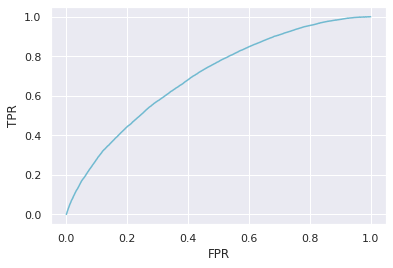

In [118]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.step(fpr, tpr, alpha = 0.9, color='c')
plt.xlabel('FPR')
plt.ylabel('TPR')


------

## Build a random forest model
Use random state 42, maximum depth from 2 to 15, and number of estimators in `[10, 20, 50, 100, 200]`

### Q4.6 What is an optimal depth and number of trees?

In [120]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 42)

params = {
   'n_estimators': [10, 20, 50, 100, 200],
   'max_depth': [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
}
 

gs2 = GridSearchCV(forest, param_grid=params,cv=5,n_jobs=-1,verbose=10)
gs2.fit(X_train,y_train)
best_forest = gs2.best_estimator_
print(best_forest)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

RandomForestClassifier(max_depth=15, n_estimators=200, random_state=42)


### Q4.7 What is the accuracy for this params?

In [121]:
best_forest.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = best_forest.predict(X_test)
round(accuracy_score(y_test, y_pred),3)

0.672

### Q4.8 Build precision-recall curve. What is the precision for recall 0.5?

In [122]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

y_prob = best_forest.predict_proba(X_test).transpose()[1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

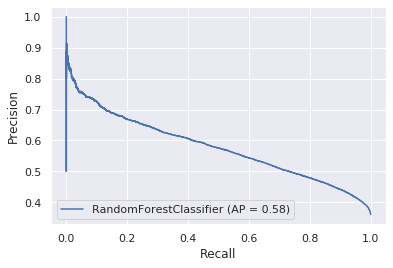

In [123]:
plot_precision_recall_curve(best_forest, X_test, y_test)

In [124]:
round(precision[(recall<=0.50001) & (recall>=0.49998)][0],3)

0.576

### Q4.9 What is the two most important features by random forest?

In [125]:
value= best_forest.feature_importances_
value= np.argsort(value)[-2:]
features = np.array(X_train.columns)
print(features[value][::-1])

['goal' 'duration_days']


------

# Build the stronger model

### Q5.1 Generate two (or more) meaningfull features

In [126]:
df = pd.read_csv('ks-projects-201801.csv')
df.set_index("ID", inplace=True)

df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)


df = df.drop(df[(df["state"] == 'undefined')].index)
df = df.drop(df[df["state"] == 'live'].index)
df = df.drop(df[df["state"] == 'suspended'].index)


df['state'].loc[(df['state']=='failed')|(df['state']=='canceled')] = 0
df['state'].loc[(df['state']=='successful')] = 1
df.state = df.state.astype(int)

In [127]:
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,US,100.0,2421.0,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,US,220.0,220.0,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,US,1.0,1.0,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,0,14,US,1283.0,1283.0,19500.00


In [128]:
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])
df['duration_days'] = (df['deadline'] - df['launched']).dt.days
df['month'] = df['deadline'].dt.month #first feature

The feature 'month' can be useful as it can affect the number of projects launched and there success due to some events that take place in the particular month.

In [129]:
launched = pd.Series(df.index, index=df.launched, name="count_7_days").sort_index()

In [130]:
count_7_days = launched.rolling('7d').count() - 1 #second feature

The second new feature was taken from here https://www.kaggle.com/matleonard/feature-generation. It showed an increase fo accuracy.

In [131]:
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(df.index)

In [132]:
df['count_7_day'] = count_7_days

In [133]:
def region(x):
    if x in ['US', 'CA', 'MX']:
        return 'america'
    elif x in ['JP', 'HK']:
        return 'asia'
    elif x in ['AU', 'NZ', 'SG']:
        return 'oceania'
    else:
        return 'europe'
    
df['region'] = df['country'].apply(lambda x: region(x))

In [134]:
df['year'] = pd.to_datetime(df['launched']).dt.year

In [135]:
df['money_day'] = df['usd_goal_real']/df['duration_days'].replace({0:1}) #third feature
df['name_length'] = df.name.apply(lambda x: w_count(x))

The third feature describes the amount of money that people have to get per day. The bigger that value the harder that is for project to be successful. Hence, that new feature can be useful.

In [136]:
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,...,usd pledged,usd_pledged_real,usd_goal_real,duration_days,month,count_7_day,region,year,money_day,name_length
ID,,,,,,,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,...,0.0,0.0,1533.95,58,10,1347.0,europe,2015,26.447414,31
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,...,100.0,2421.0,30000.00,59,11,946.0,america,2017,508.474576,45
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,...,220.0,220.0,45000.00,44,2,739.0,america,2013,1022.727273,14
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,...,1.0,1.0,5000.00,29,4,906.0,america,2012,172.413793,49
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,0,14,...,1283.0,1283.0,19500.00,55,8,1373.0,america,2015,354.545455,58


In [137]:
df = df.drop(columns = ['name', 'deadline', 'goal', 'launched', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real'])

In [138]:
df.head()

,category,main_category,currency,state,country,usd_goal_real,duration_days,month,count_7_day,region,year,money_day,name_length
ID,,,,,,,,,,,,,
1000002330,Poetry,Publishing,GBP,0,GB,1533.95,58,10,1347.0,europe,2015,26.447414,31
1000003930,Narrative Film,Film & Video,USD,0,US,30000.00,59,11,946.0,america,2017,508.474576,45
1000004038,Narrative Film,Film & Video,USD,0,US,45000.00,44,2,739.0,america,2013,1022.727273,14
1000007540,Music,Music,USD,0,US,5000.00,29,4,906.0,america,2012,172.413793,49
1000011046,Film & Video,Film & Video,USD,0,US,19500.00,55,8,1373.0,america,2015,354.545455,58


In [139]:
for col in ['category', 'main_category', 'region', 'country', 'currency']: 
    ohe_df = ohe_col_transform(df,col_name=col)
    ohe_df.index = df.index
    df = pd.concat([df, ohe_df], axis=1).drop([col], axis=1)

In [140]:
from sklearn.model_selection import train_test_split

y = df.state
X = df.drop(columns = ['state'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [141]:
df.head()

,state,usd_goal_real,duration_days,month,count_7_day,year,money_day,name_length,category_3D Printing,category_Academic,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
ID,,,,,,,,,,,,,,,,,,,,,
1000002330,0,1533.95,58,10,1347.0,2015,26.447414,31,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000003930,0,30000.00,59,11,946.0,2017,508.474576,45,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1000004038,0,45000.00,44,2,739.0,2013,1022.727273,14,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1000007540,0,5000.00,29,4,906.0,2012,172.413793,49,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1000011046,0,19500.00,55,8,1373.0,2015,354.545455,58,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [142]:
X_train = normalize(X_train,scaler,['usd_goal_real', 'duration_days', 'month', 'year', 'money_day','name_length','count_7_day'])
X_test = normalize(X_test,scaler,['usd_goal_real', 'duration_days', 'month', 'year', 'money_day','name_length','count_7_day'])

### Q5.2 Train an xgboost that beats random forest

In [143]:
from xgboost import XGBClassifier

In [145]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    max_depth = 8,
    n_estimators = 140,
    learning_rate = 0.1, 
    nthread=6,
    seed=42
)

In [146]:
estimator.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=6, nthread=6, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [147]:
y_pred = estimator.predict(X_test)
round(accuracy_score(y_test, y_pred),3)

0.695